In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import IPython.display as ipd

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
import librosa
from librosa.display import specshow
from librosa.display import waveshow
from librosa.feature import melspectrogram
from librosa.feature import mfcc

###### Exploratory analysis

###### Case study

In [55]:
"""
Wave & features
"""
def _padd(wav, sr):
    if wav.shape[0] < 5*sr:
        wav=np.pad(wav, int(np.ceil((5*sr - wav.shape[0])/2)), mode='reflect')
    else:
        wav=wav[:5*sr]
    return wav


def _continuous2discrete(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled


def get_wave(path, sr=None):
    wav, sr = librosa.load(path, sr=sr)
    return wav, sr


def get_feature(wav,
                add_padding=True,
                add_db=True,
#                 discrete=True,
                discrete=False,
                feature=melspectrogram,
                  sr=None,
                  n_fft=2048, 
                  hop_length=512, 
                  n_mels=128, 
                  fmin=20, 
                  fmax=8300, 
                  top_db=80,
                   eps=1e-6):
    
    if add_padding:
        wav = _padd(wav, sr)
    
    spec = feature(wav, 
                  sr=sr,
                  n_fft=n_fft,
                  hop_length=hop_length,
                  n_mels=n_mels,
                  fmin=fmin,
                  fmax=fmax)

    if add_db:
        spec = librosa.power_to_db(spec, top_db=top_db)
    
    if discrete:
        spec = _continuous2discrete(spec, eps=eps)
    
    return spec



"""
Plot
"""
def plot_audio(path):
    return ipd.Audio(path)


def plot_wave(wav, title="wave"):
    waveshow(wav, x_axis='time')
    plt.title(title)
    plt.show()
    
    
def plot_feature(feature, title="melspectrogram"):
    specshow(feature, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.title(title)
    plt.show()
    

    
"""
Case study
"""
def audio_info(path, 
               sr=None, 
               features_dct={"melspectrogram": melspectrogram,
                             "mfcc": mfcc}):

    wav, sr = librosa.load(path, sr=sr)
    plot_wave(wav)
    for name, feature in features_dct.items():
        f = get_feature(wav, sr=sr, feature=feature)
        plot_feature(f, title=name)
    return plot_audio(path)

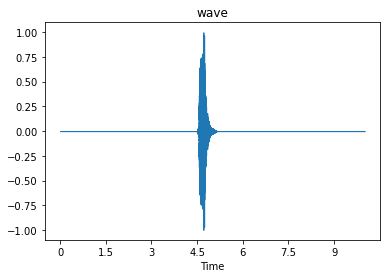

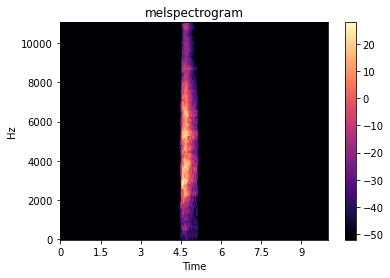

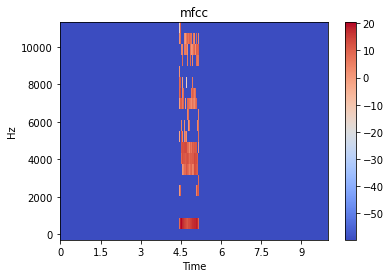

In [56]:
audio_info('../ESC-50-master/audio/1-100032-A-0.wav')

###### Construct Datasets

In [179]:
"""
DF
"""
def get_target_description(df):
    return df[["target", "category"]].groupby("target").first()


def get_target_distribution(df, title="distribution_of_targets", ax=None, show=False):
    ax = df.target.hist(bins=50, alpha=0.5, edgecolor="black", ax=ax)
    ax.set_xlabel("target")
    ax.set_ylabel("number_of_data_points")
    if show:
        plt.title(title)
        plt.show()
    else:
        return ax
    
    
def get_folds(df):
    fold_dct = dict()
    for fold in df.fold.unique():
        fold_dct[fold] = df[df.fold == fold]
    return fold_dct


def folds_info(dct):
    print(f"Number_of_folds: {len(dct)}")
    print()
    for i, fold in dct.items():
        print(f"fold: {i} | size: {fold.shape[0]}")
    print()
    
    
def get_fold_distribution(dct):
    print("Distribution of targets across folds:")
    fig, axs = plt.subplots(nrows=1, ncols=len(dct), figsize=(20, 2))
    for i, fold in dct.items():
        _ax = axs[i - 1]
        get_target_distribution(fold, ax=_ax)
        _ax.set_title(f"fold_{i}")
    plt.show()         
        
        
def get_df(path, only_esc10=True):
    df = pd.read_csv(path)
    if only_esc10:
        df = df[df.esc10 == True]
    return df
        

def extract_data(path, only_esc10=True):
    
    if only_esc10:
        print(f"Use only 10 classes!")
        print()
        
    df = get_df(path, only_esc10=only_esc10)
    
    folds = get_folds(df)
    folds_info(folds)
    get_fold_distribution(folds)
    
    info_df = get_target_description(df)    
        
    return info_df, df


def train_test_split(df, test_fold=1):
    train_df = df[df.fold != test_fold]
    test_df = df[df.fold == test_fold]
    return train_df, test_df



"""
Dataset
"""
class ESC50Data(Dataset):
    
    def __init__(self, 
                 df,
                 feature=melspectrogram,
                 base_dir='../ESC-50-master/audio', 
                 in_col='filename', 
                 out_col='category'):
                ### add args
        
        self.df = df
        self.data = []
        self.labels = []
        self.c2i={}
        self.i2c={}
        self.categories = sorted(df[out_col].unique())

        for i, category in enumerate(self.categories):
            self.c2i[category] = i
            self.i2c[i] = category
            
        for ind in tqdm(range(len(df))):
            row = df.iloc[ind]
            file_path = os.path.join(base_dir, row[in_col])
            self.labels.append(self.c2i[row[out_col]])
            
            wav, sr = get_wave(file_path)
            point_feature = get_feature(wav, sr=sr, feature=feature)
            self.data.append(point_feature[np.newaxis,...])
            
            
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
    

    
"""
Loader
"""    
def get_loaders(df,
                feature=melspectrogram,
                test_fold=1, 
                batch_size=16,
                
                shuffle=True):
    
    train_df, test_df = train_test_split(df, test_fold=test_fold)
    print("Construct loaders...")
    print("train_data:")
    train_data = ESC50Data(train_df, feature=feature)
    print("test_data:")
    test_data = ESC50Data(test_df, feature=feature)
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader


def get_loaders_from_csv(path, 
                         only_esc10=True, 
                         test_fold=1, 
                         batch_size=16, 
                         shuffle=True, 
                         feature=melspectrogram):
    
    
    info_df, df = extract_data(path, only_esc10=only_esc10)
    print("targets:")
    print(info_df)
    print()
    train_loader, test_loader = get_loaders(df,
                                            feature=feature,
                                            test_fold=test_fold, 
                                            batch_size=batch_size,
                                            shuffle=shuffle)
    
    ##### настроить k-fold валидацию !
    ##### добавить аргументы!
    
    return train_loader, test_loader

Use only 10 classes!

Number_of_folds: 5

fold: 1 | size: 80
fold: 2 | size: 80
fold: 3 | size: 80
fold: 4 | size: 80
fold: 5 | size: 80

Distribution of targets across folds:


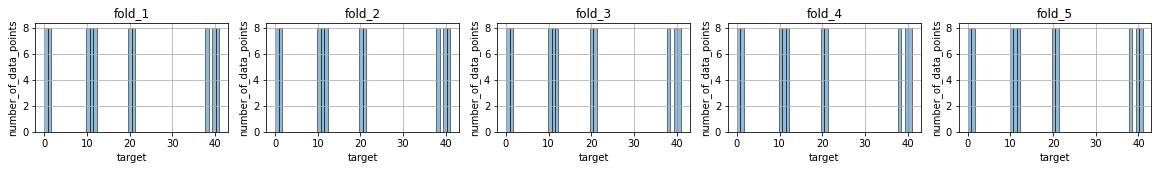

targets:
              category
target                
0                  dog
1              rooster
10                rain
11           sea_waves
12      crackling_fire
20         crying_baby
21            sneezing
38          clock_tick
40          helicopter
41            chainsaw

Construct loaders...
train_data:


100%|█████████████████████████████████████████| 320/320 [00:08<00:00, 36.53it/s]


test_data:


100%|███████████████████████████████████████████| 80/80 [00:02<00:00, 37.76it/s]


In [180]:
train_loader, test_loader = get_loaders_from_csv(csv_path)

###### MODEL

In [181]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision.models import resnet34

In [186]:
def get_device():
    return torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')


def get_model(device):
    resnet_model = resnet34(pretrained=True)
    resnet_model.fc = nn.Linear(512, 50)
    resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    resnet_model = resnet_model.to(device)
    
    return resnet_model


def lr_decay(optimizer, epoch):
    if epoch%10==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer = setlr(optimizer, new_lr) ######################### ?????
        print(f'Changed learning rate to {new_lr}')
    return optimizer


def train(model, 
          loss_fn, 
          train_loader, 
          valid_loader, 
          epochs, 
          optimizer, 
          train_losses, 
          valid_losses, 
          change_lr=None):
      
    for epoch in tqdm(range(1, epochs+1)):
        model.train()
        batch_losses=[]
        if change_lr:
            optimizer = change_lr(optimizer, epoch) #### ???
            
        for i, data in enumerate(train_loader):
            x, y = data
            optimizer.zero_grad()
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            
            y_hat = model(x)
            
            loss = loss_fn(y_hat, y)
            loss.backward()
            batch_losses.append(loss.item())
            optimizer.step()
            
        train_losses.append(batch_losses)
        
        print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
        
        model.eval()
        batch_losses=[]
        trace_y = []
        trace_yhat = []
        
        for i, data in enumerate(valid_loader):
            x, y = data
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            trace_y.append(y.cpu().detach().numpy())
            trace_yhat.append(y_hat.cpu().detach().numpy())      
            batch_losses.append(loss.item())
            
        valid_losses.append(batch_losses)
        trace_y = np.concatenate(trace_y)
        trace_yhat = np.concatenate(trace_yhat)
        accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
        
        print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')
    



In [185]:
device = get_device()
model = get_model(device)

learning_rate = 2e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 50
loss_fn = nn.CrossEntropyLoss()
resnet_train_losses=[]
resnet_valid_losses=[]


train(model, 
      loss_fn, 
      train_loader,
      test_loader,
      epochs,
      optimizer, 
      resnet_train_losses, 
      resnet_valid_losses, 
      lr_decay)


  0%|                                                    | 0/50 [00:05<?, ?it/s]


KeyboardInterrupt: 